# **Hate Speech & Offensive Language Detection using Fine-tuned DistilBERT**

Hate Speech Detection using Fine-tuned DistilBERT

One of the greatest barriers in creating safe and welcoming online communities is the widespread of hate speech on social media platforms. One of the most important tools for reducing the negative effects of such harsh language is automated hate speech detection. The goal of this project is to use transformational networks to create a strong hate speech detection model. Specifically, using a dataset of tagged tweets to refine a DistilBERT model and categorise them into three groups: hate speech, offensive language, or neither.

The primary research question is: Can a fine-tuned DistilBERT model effectively classify tweets as hate speech, offensive language, or neither? In addition, this project aimed to:

Analyze the impact of class imbalance on model performance. Evaluate the model's performance using various metrics, including accuracy, precision, recall, and F1-score. Discuss the ethical considerations and limitations associated with hate speech detection.

This project uses the Kaggle Hate Speech dataset, a publicly available collection of tweets labeled as hate speech, offensive language, or neither. This dataset is well-suited for the research question due to its direct relevance to hate speech detection and the availability of labeled data for supervised learning.

The dataset comprises the following columns:

tweet: The textual content of the tweet. class: The label indicating whether the tweet is hate speech (0), offensive language (1), or neither (2).

### **WARNING!**
This project; the data, the notebook and report all contain content that is offensive, sexist, racist and homofobic in many other ways.

In [1]:
!pip install transformers
!pip install datasets
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.7 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

**1. Data Loading and Exploration**

In [3]:
# Reading the data
df = pd.read_csv("/content/labeled_data.csv")
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [4]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [5]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

**Columns Key:**

count = number of users who coded each tweet.

hate_speech = number of users who judged the tweet to be hate speech.

offensive_language = number of users who judged the tweet to be offensive.

neither = number of users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of users.

0 - hate speech
1 - offensive  language
2 - neither
tweet = raw tweet text

<ipython-input-6-62a8fa35d74c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette=['skyblue', 'purple', 'green'])


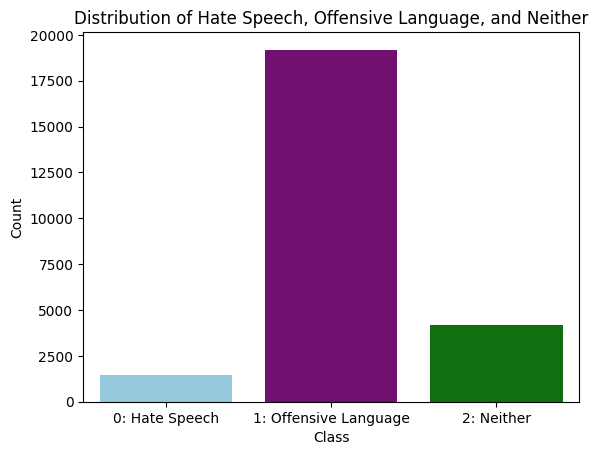

In [6]:
# Displaying distribution of classes
sns.countplot(x='class', data=df, palette=['skyblue', 'purple', 'green'])
plt.title('Distribution of Hate Speech, Offensive Language, and Neither')
plt.xlabel('Class')
plt.ylabel('Count')

plt.xticks([0, 1, 2], ['0: Hate Speech', '1: Offensive Language', '2: Neither'])

plt.show()

The plot above shows that the majority of tweets are labeled as offensive language, while hate speech constitutes a minority class. This class imbalance poses a challenge for model training, as the model might be biased towards the majority class.

In [7]:
class_counts = df['class'].value_counts()
print("Class Distribution:\n", class_counts)
print("\nPercentage Distribution:\n", class_counts / class_counts.sum() * 100)

Class Distribution:
 class
1    19190
2     4163
0     1430
Name: count, dtype: int64

Percentage Distribution:
 class
1    77.432111
2    16.797805
0     5.770084
Name: count, dtype: float64


------

2. Data Cleaning

Before analyzing and modelling the data, we need to clean it to remove any irrelevant information that might affect the results. This step is crucial for ensuring that our model learns from the meaningful content of the tweets and not from irrelevant artifacts. However, we also want to avoid over-cleaning, which could remove valuable linguistic features that contribute to hate speech detection.

Here are the cleaning steps we'll perform:

**Removing Mentions, URLs and stopwords:** We'll remove any mentions (@username) and URLs from the tweets, as these don't contribute to the sentiment or hate speech classification. Hate speech detection often relies on subtle cues and context. While DistilBERT can handle some noise, removing stopwords can help it focus on the more meaningful terms that contribute to hate speech.

**Removing punctuations**

This approach balances the need for clean data with the importance of preserving linguistic features that are relevant to our task.

In [8]:
import nltk
import re
import pandas as pd # Make sure you have pandas imported

# Downloading required NLTK resources
nltk.download('stopwords')

# Stop words and exclusions
stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff"]
stopwords.extend(other_exclusions)

# Cleaning the data (removing mentions, punctuation, and RT)
def remove_punctuation(text):
    """Removes all punctuation and special characters from a string."""
    return re.sub(r'[^\w\s]', '', text)  # Keep only alphanumeric and whitespace

def remove_rt(tweet):
    """Removes 'RT' from the tweet."""
    tweet = tweet.replace("RT ", "").replace("rt ", "") # add this line
    return tweet

df['tweet_cleaned'] = df['tweet'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
df['tweet_cleaned'] = df['tweet_cleaned'].apply(remove_punctuation)
df['tweet_cleaned'] = df['tweet_cleaned'].apply(remove_rt) # add this line

# Removing stopwords
def remove_stopwords(text):
    """Removes stop words from a string."""
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(filtered_words)

df['tweet_cleaned'] = df['tweet_cleaned'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet_cleaned
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain cleaning house amp man...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad cuffin dat hoe 1st p...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Dawg ever fuck bitch stato cry confused shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,_G_Anderson _based look like tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya...


Below, the distribution of tweet lengths across different classes are analyzed to see if there are any noticeable patterns. For this, histograms were used to visualize and compare the tweet lengths.

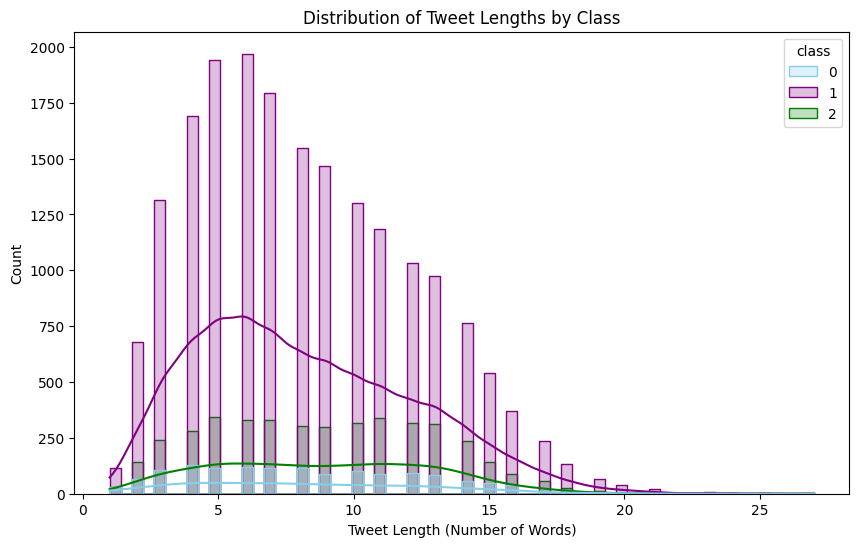

In [10]:
# Calculating tweet lengths (number of words)
df['tweet_length'] = df['tweet_cleaned'].apply(lambda x: len(x.split()))

# histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tweet_length', hue='class', element='step', kde=True, palette=['skyblue', 'purple', 'green'])
plt.title('Distribution of Tweet Lengths by Class')
plt.xlabel('Tweet Length (Number of Words)')
plt.ylabel('Count')
plt.show()

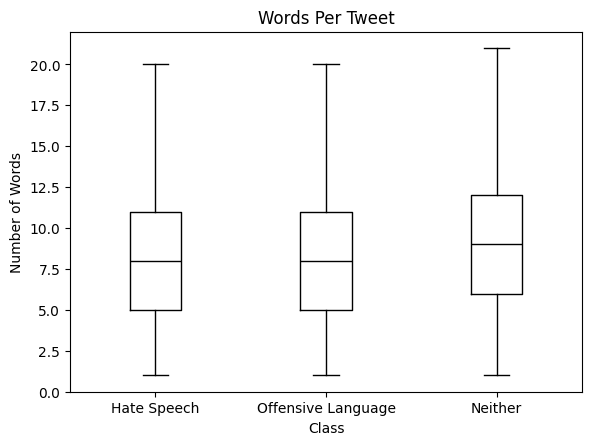

In [11]:
df["Words Per Tweet"] = df["tweet_cleaned"].str.split().apply(len)

df.boxplot("Words Per Tweet", by="class", grid=False, showfliers=False, color="black")

plt.suptitle("")  # Remove the default title
plt.xlabel("Class")  # Add a more descriptive x-axis label
plt.ylabel("Number of Words") # add a y label
plt.xticks([1, 2, 3], ['Hate Speech', 'Offensive Language', 'Neither'])

plt.show()

3. Word Clouds and Word Frequency Analysis

This section analyses which words are most frequently used in each class using word clouds. This can help identifying key terms and phrases associated with hate speech, offensive language, and neutral tweets.

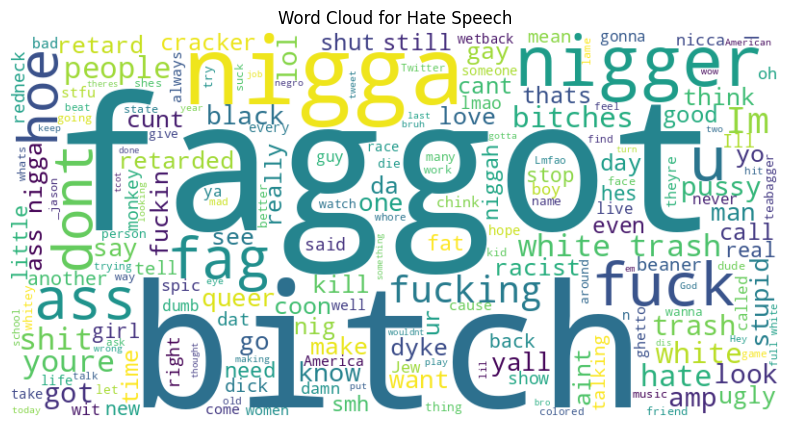

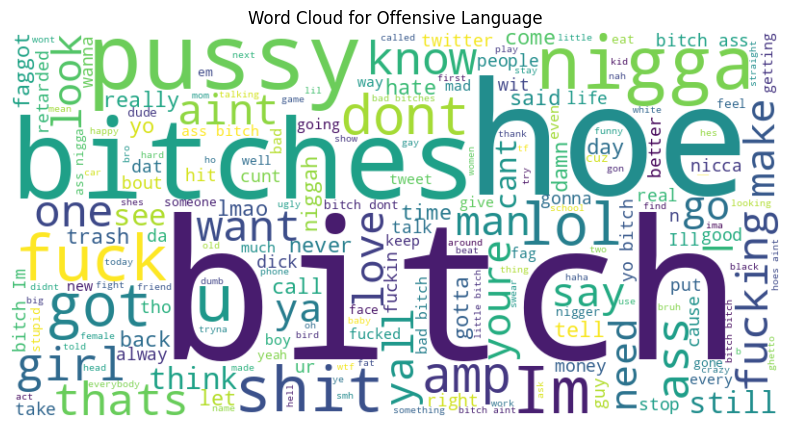

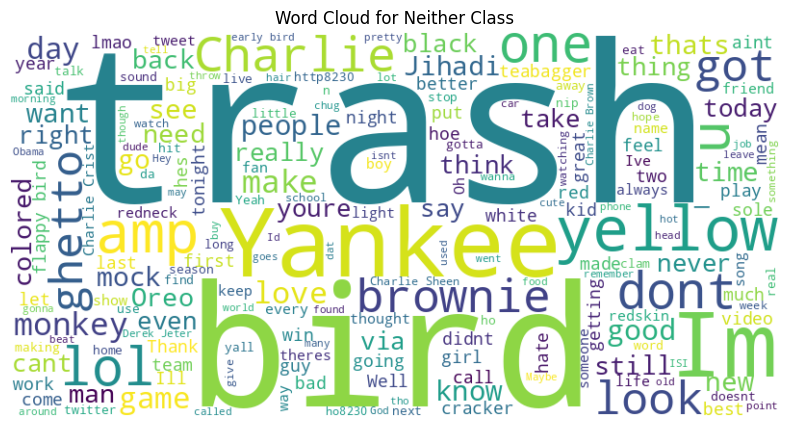

In [12]:
from wordcloud import WordCloud, STOPWORDS

# Combining all tweets for each class
hate_words = ' '.join(df[df['class'] == 0]['tweet_cleaned'])
offensive_words = ' '.join(df[df['class'] == 1]['tweet_cleaned'])
neither_words = ' '.join(df[df['class'] == 2]['tweet_cleaned'])

# Generating word clouds
wordcloud_hate = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(hate_words)
wordcloud_offensive = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(offensive_words)
wordcloud_neither = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(neither_words)

# Displaying word clouds

# Hate Speech
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_hate, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Hate Speech')
plt.show()

# Offensive
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_offensive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Offensive Language')
plt.show()

# Neither
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neither, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Neither Class')
plt.show()

The bar charts below show the top 10 words that are most distinctive for each class. It designed as blue bars indicate words that are more frequent in the given class compared to the other classes, while red bars indicate words that are less frequent. But as it can be seen there are no red bars in the output of the word frequency analysis which means that there are no words that are significantly less frequent in a given class compared to the other classes.

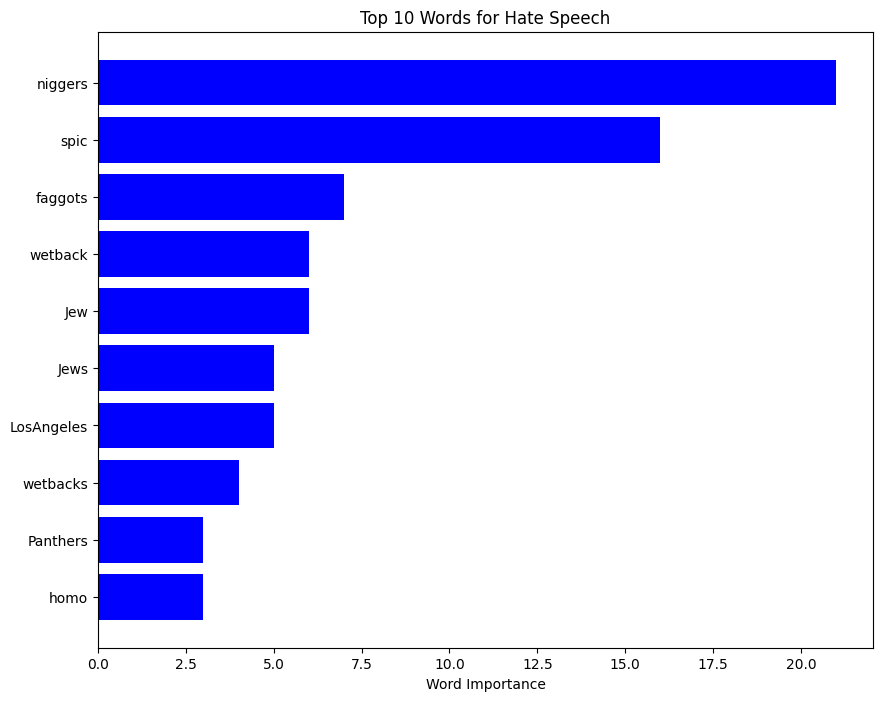

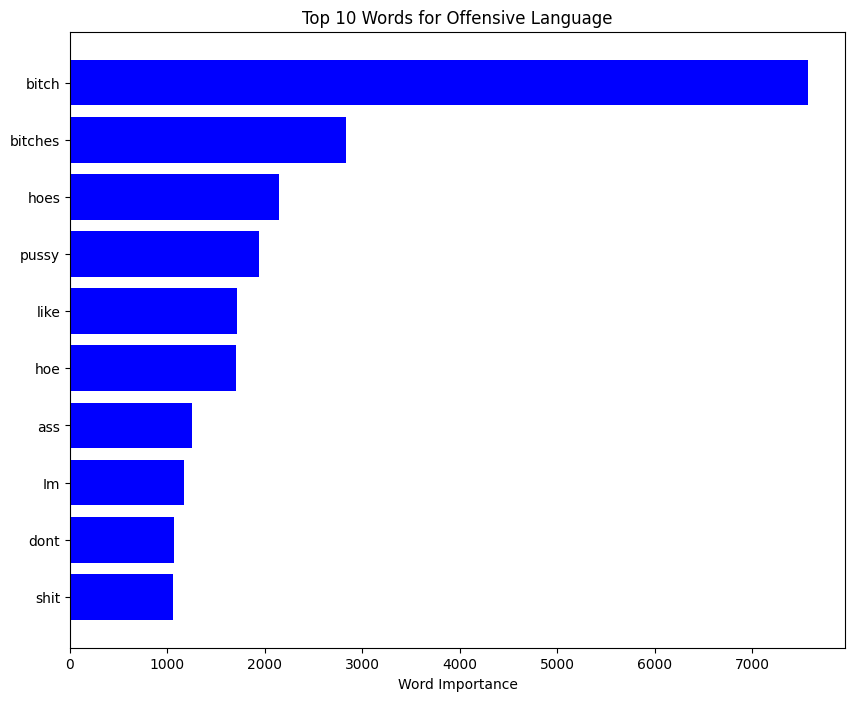

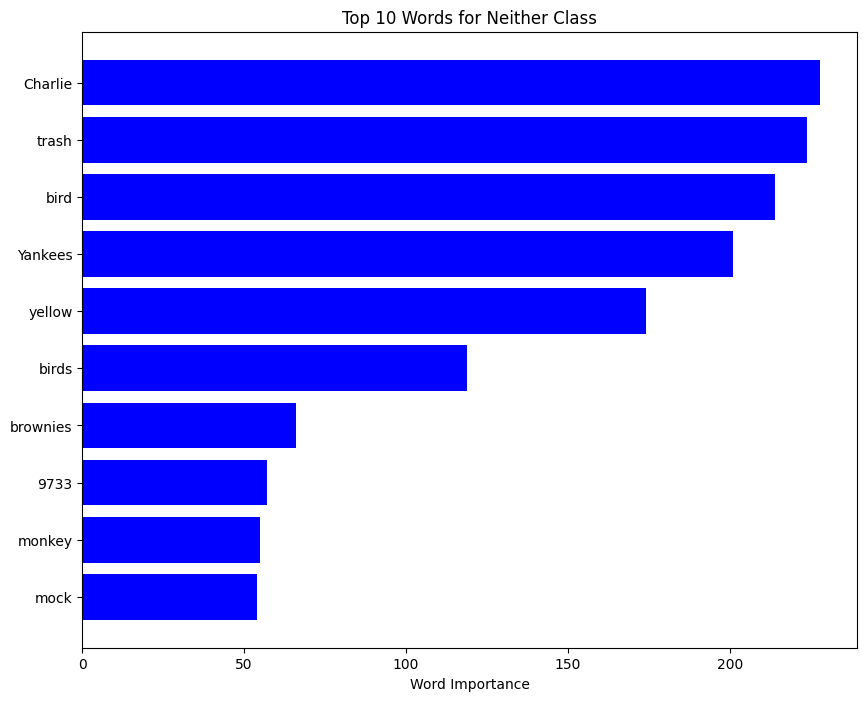

In [13]:
# --- Word Frequency Analysis ---
from collections import Counter

def get_top_words(df, class_label):
    class_words = ' '.join(df[df['class'] == class_label]['tweet_cleaned']).split()
    other_words = ' '.join(df[df['class'] != class_label]['tweet_cleaned']).split()
    class_counts = Counter(class_words)
    other_counts = Counter(other_words)
    word_importance = {word: class_counts[word] - other_counts[word] for word in class_counts}
    top_10_words = Counter(word_importance).most_common(10)
    return top_10_words

hate_top_words = get_top_words(df, 0)
offensive_top_words = get_top_words(df, 1)
neither_top_words = get_top_words(df, 2)

def create_bar_chart(top_words, class_name):
    words, scores = zip(*top_words)
    colors = ['blue' if score > 0 else 'red' for score in scores]
    plt.figure(figsize=(10, 8))
    plt.barh(words, scores, color=colors)
    plt.xlabel('Word Importance')
    plt.title(f'Top 10 Words for {class_name}')
    plt.gca().invert_yaxis()
    plt.show()

create_bar_chart(hate_top_words, 'Hate Speech')
create_bar_chart(offensive_top_words, 'Offensive Language')
create_bar_chart(neither_top_words, 'Neither Class')

The word frequency analysis revealed that there were no words that were significantly less frequent in a specific class compared to the others. However, we identified several words that were significantly more frequent in each class, as shown by the blue bars in the bar charts.

4. Splitting

The dataset was split into training, validation, and test sets using a 70-15-15 stratified split. This ensures that the class distribution is maintained across the splits, which is crucial for addressing the class imbalance issue.

In [14]:
from datasets import Dataset, DatasetDict
# Splitting the dataset
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({'train': train_dataset, 'valid': val_dataset, 'test': test_dataset})
dataset = dataset.remove_columns(['hate_speech', 'offensive_language', 'neither', 'Unnamed: 0', 'count'])

In [15]:
# Printing the dataset sizes
print(f"Train dataset size: {len(dataset['train'])}")
print(f"Validation dataset size: {len(dataset['valid'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Train dataset size: 17348
Validation dataset size: 3717
Test dataset size: 3718


5.  Tokenization

The DistilBERT tokenizer used to convert the tweets into numerical representations suitable for the model. This process involved padding and truncating sequences to a maximum length of 512.

In [16]:
# Tokenization part
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples['tweet_cleaned'], padding='max_length', truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Sample Tokenized Output
print("Sample tokenized output:")
print(tokenized_dataset['train'][0])

# Max Tokenized Sequence Length
max_length = max([len(seq) for seq in tokenized_dataset['train']['input_ids']])
print(f"Max tokenized sequence length: {max_length}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/17348 [00:00<?, ? examples/s]

Map:   0%|          | 0/3717 [00:00<?, ? examples/s]

Map:   0%|          | 0/3718 [00:00<?, ? examples/s]

Sample tokenized output:
{'class': 2, 'tweet': 'RT @BeardedBearsMan: @007BearDownJedi The AFL now has an American draft system #BearBrother! Couple of Yanks are on the playing lists at so&#8230;', 'tweet_cleaned': 'AFL American draft system BearBrother Couple Yanks playing lists so8230', 'tweet_length': 10, 'Words Per Tweet': 10, '__index_level_0__': 14336, 'input_ids': [101, 9835, 1237, 5039, 1449, 8073, 2064, 21941, 1200, 3291, 4455, 1513, 14932, 4616, 1773, 6802, 1177, 1604, 22737, 1568, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

6. TensorFlow Dataset Creation

The DistilBERT was selected for this task due to its suitability for text classification and its efficiency compared to larger transformer models like BERT. DistilBERT is a smaller, faster, and lighter version of BERT that retains much of its performance, making it a good choice for this project.

The DistilBERT model was fine-tuned using the following settings:

Batch size: 8

Epochs: 2 (with early stopping)

Learning rate: 2e-5 (with an exponential decay scheduler)

The project also uses the Adam optimizer, SparseCategoricalCrossentropy loss function, and SparseCategoricalAccuracy metric for training. Callbacks such as ModelCheckpoint and EarlyStopping were employed to prevent overfitting and save the best model based on validation performance.

In [22]:
# Dataset Creation w/ TensorFlow
train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['valid']
test_dataset = tokenized_dataset['test']

train_set = train_dataset.remove_columns(['tweet', "tweet_cleaned"]).with_format('tensorflow')
tf_eval_dataset = eval_dataset.remove_columns(['tweet', "tweet_cleaned"]).with_format('tensorflow')
tf_test_dataset = test_dataset.remove_columns(['tweet', "tweet_cleaned"]).with_format('tensorflow')

batch_size = 8
train_features = {x: train_set[x] for x in tokenizer.model_input_names}
train_set_for_final_model = tf.data.Dataset.from_tensor_slices((train_features, train_set['class'])).shuffle(len(train_set)).batch(batch_size)

eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
val_set_for_final_model = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset["class"])).batch(batch_size)

test_features = {x: tf_test_dataset[x] for x in tokenizer.model_input_names}
test_set_for_final_model = tf.data.Dataset.from_tensor_slices((test_features, tf_test_dataset["class"])).batch(batch_size)

#  Displaying batch shape
for batch in train_set_for_final_model.take(1):
    print("Batch shape:", {k: v.shape for k, v in batch[0].items()})
    print("Batch label shape:", batch[1].shape)

Batch shape: {'input_ids': TensorShape([8, 512]), 'attention_mask': TensorShape([8, 512])}
Batch label shape: (8,)


7. Model Training

In [23]:
import torch
# Model Training
learning_rate = 2e-5
epochs = 2

# Device Checking (PyTorch)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device == torch.device("cuda"):
    # If GPU, use GPU
    model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=3)
else:
    # If CPU, use CPU
    with tf.device("/CPU:0"):
        model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=3)


# Using DistilBERT instead of BERT-base-cased
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=3)

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,
    decay_rate=0.9
)

Using device: cuda


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

checkpoint_filepath = './best_model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [25]:
# Calculating class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_df['class']), y=train_df['class'])
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Model Fitting (with class weights)
history = model.fit(
    train_set_for_final_model,
    validation_data=val_set_for_final_model,
    epochs=epochs,
    callbacks=[model_checkpoint_callback, early_stopping_callback],
    class_weight=class_weights_dict  # Adding the class weights here
)

Epoch 1/2
2169/2169 [==============================] - 1046s 474ms/step - loss: 0.5607 - sparse_categorical_accuracy: 0.7897 - val_loss: 0.5882 - val_sparse_categorical_accuracy: 0.7657
Epoch 2/2
2169/2169 [==============================] - 1014s 468ms/step - loss: 0.4241 - sparse_categorical_accuracy: 0.8177 - val_loss: 0.4356 - val_sparse_categorical_accuracy: 0.8609


8. Attention Matrix Visualization

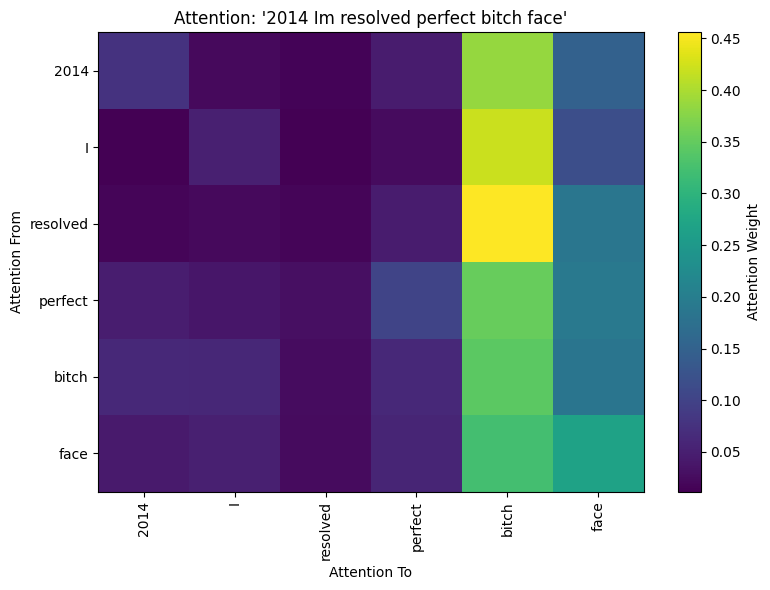

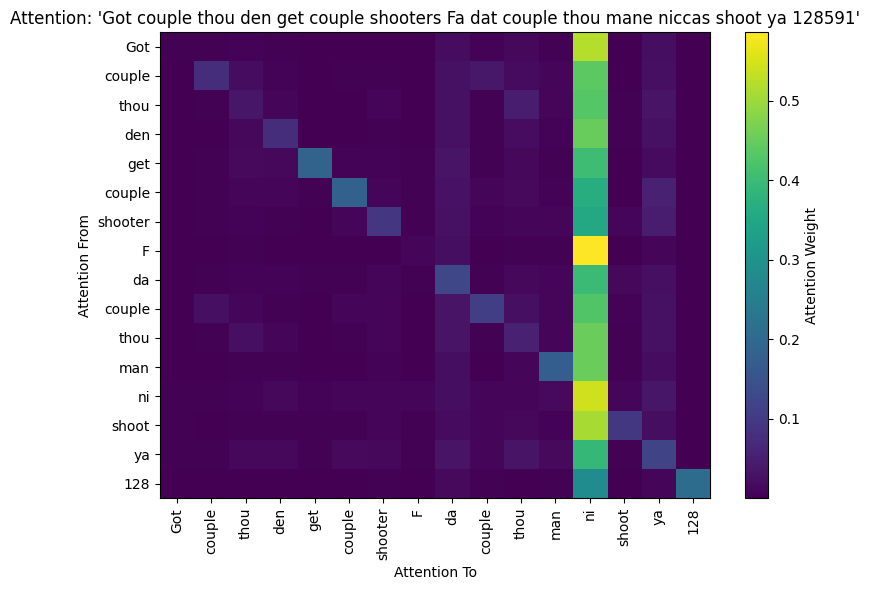

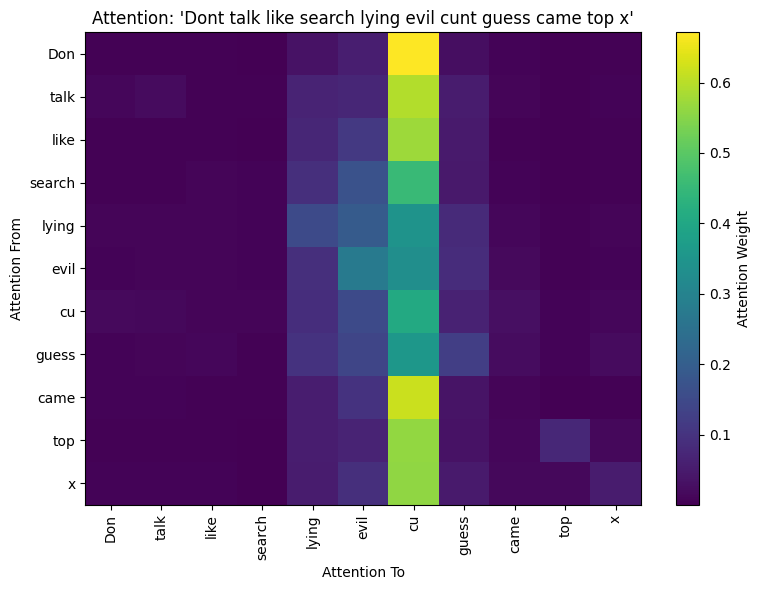

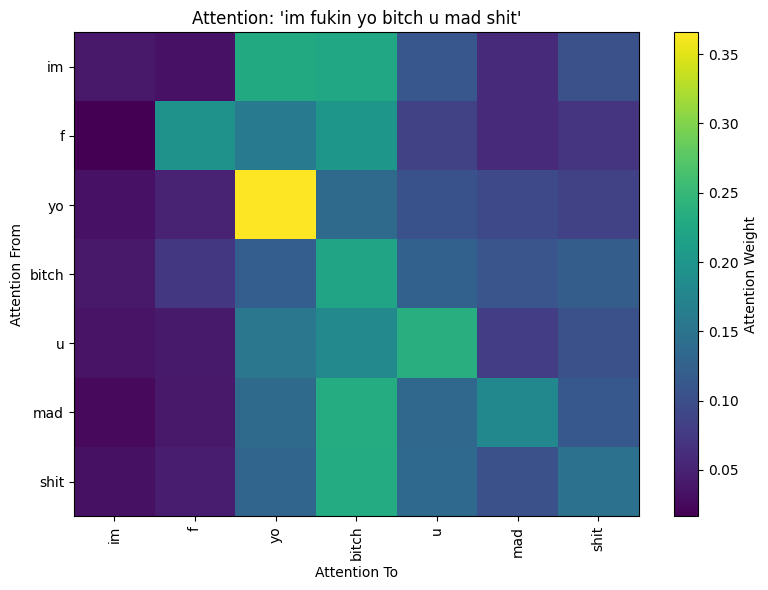

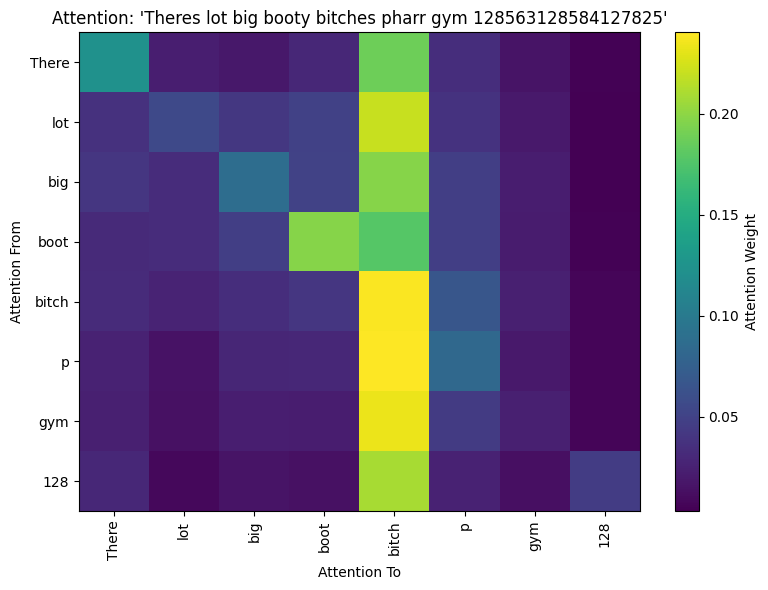

In [26]:
import random
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import matplotlib.pyplot as plt
import re


def plot_attention_heatmap(tweet, tokenizer, model, title="Attention Heatmap"):
    """Plots an attention heatmap for a given tweet, excluding special tokens."""
    inputs = tokenizer(tweet, return_tensors="tf")
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions[-1]
    final_attention_matrix = tf.reduce_mean(attentions, axis=1).numpy().squeeze(0)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].numpy())

    # Removing special tokens and subword markers
    valid_indices = [i for i, token in enumerate(tokens) if token not in ["[CLS]", "[SEP]"] and not re.match(r'^##', token)]
    filtered_tokens = [tokens[i] for i in valid_indices]
    filtered_attention_matrix = final_attention_matrix[np.ix_(valid_indices, valid_indices)]

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(filtered_attention_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.xticks(ticks=np.arange(len(filtered_tokens)), labels=filtered_tokens, rotation=90)
    plt.yticks(ticks=np.arange(len(filtered_tokens)), labels=filtered_tokens)
    plt.title(title)
    plt.xlabel("Attention To")
    plt.ylabel("Attention From")
    plt.tight_layout()
    plt.show()

# Selecting 5 random samples from the test set
num_samples = 5
test_set_size = len(tokenized_dataset['test'])
random_indices = random.sample(range(test_set_size), num_samples)

# Generating attention heatmaps for the selected samples
for index in random_indices:
    sample = tokenized_dataset['test'][index]
    tweet = sample['tweet_cleaned']
    plot_attention_heatmap(tweet, tokenizer, model, title=f"Attention: '{tweet}'")

9. Evaluation plots of model

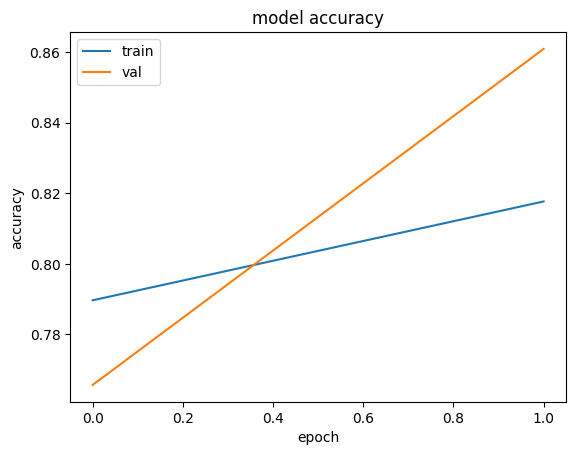

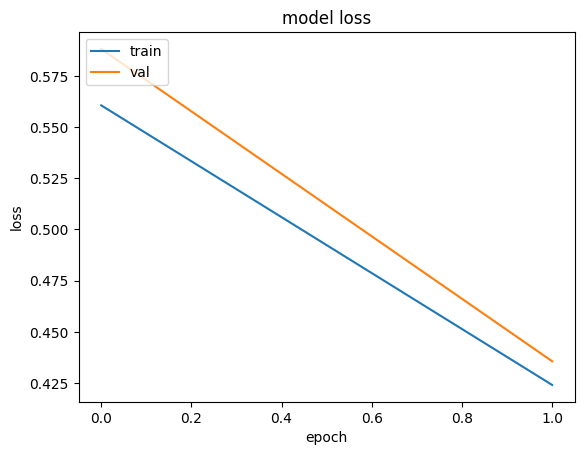

In [27]:
# Evaluation Plots
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

10. Detailed Evaluation

To assess the model's performance the following metrics were used:

Accuracy: The proportion of correctly classified tweets.

Precision: The proportion of correctly predicted positive instances out of all predicted positive instances.

Recall: The proportion of correctly predicted positive instances out of all actual positive instances.

F1-score: The harmonic mean of precision and 1 recall.

Confusion matrix: A visualization of the model's predictions versus the true labels, showing the distribution of correct and incorrect classifications.

465/465 [==============================] - 71s 146ms/step


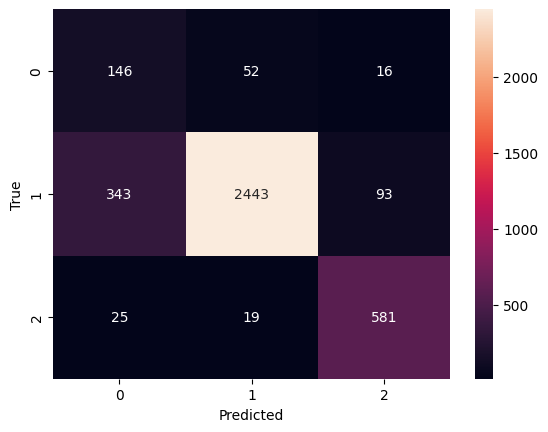

Accuracy: 0.8526
Precision: 0.9104
Recall: 0.8526
F1 Score: 0.8732

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.68      0.40       214
           1       0.97      0.85      0.91      2879
           2       0.84      0.93      0.88       625

    accuracy                           0.85      3718
   macro avg       0.70      0.82      0.73      3718
weighted avg       0.91      0.85      0.87      3718



In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Detailed Evaluation
y_true = np.concatenate([y for x, y in test_set_for_final_model], axis=0)

predictions = model.predict(test_set_for_final_model)

# Extracting the logits
logits = predictions.logits

y_pred = np.argmax(logits, axis=1)  # Using the logits for argmax

# Confusion matrix heatmap
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Extracting metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Printing metrics with labels
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Printing the classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))

In [31]:
# Prediction part
predict_score_and_class_dict = {0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neither'}
test_sentences = ["I am sick of your trash.", "You white people don’t deserve to exist. Stay away from us.", "That guy sucks.", "You're such an idiot, I can't stand talking to you."]
preds = model(tokenizer(test_sentences, return_tensors="tf", padding=True, truncation=True))['logits']
probabilities = tf.nn.softmax(preds, axis=1).numpy()
class_preds = np.argmax(preds, axis=1)

for i, pred in enumerate(class_preds):
    print(f"Sentence: '{test_sentences[i]}'")
    print(f"Predicted Class: {predict_score_and_class_dict[pred]}")
    print(f"Probability Scores: {probabilities[i]}")

Sentence: 'I am sick of your trash.'
Predicted Class: Neither
Probability Scores: [0.23748484 0.05427459 0.70824057]
Sentence: 'You white people don’t deserve to exist. Stay away from us.'
Predicted Class: Hate Speech
Probability Scores: [0.7456149  0.05240503 0.20198008]
Sentence: 'That guy sucks.'
Predicted Class: Offensive Language
Probability Scores: [0.33910066 0.6104455  0.05045389]
Sentence: 'You're such an idiot, I can't stand talking to you.'
Predicted Class: Hate Speech
Probability Scores: [0.592552   0.38532802 0.02211998]


**Conclusion:**

This project demonstrated the potential of fine-tuning DistilBERT for hate speech detection. However, challenges such as class imbalance and the complexity of hate speech need to be addressed to improve performance. Future work could explore data augmentation techniques, alternative models, and more robust evaluation metrics.

The use of machine learning for hate speech detection holds promise, but it requires careful consideration of ethical implications and continuous efforts to mitigate bias and improve accuracy.